<a href="https://colab.research.google.com/github/BernieT7/my-process/blob/main/pytorch%26logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/GrandmaCan/ML/main/Classification/Diabetes_Data.csv"
data = pd.read_csv(url)
data

,Age,Weight,BloodSugar,Gender,Diabetes
0,25,119,130.8,男生,1
1,66,102,128.1,女生,1
2,59,65,103.9,男生,0
3,46,117,94.8,女生,0
4,45,79,57.8,男生,0
...,...,...,...,...,...
395,72,63,97.1,女生,0
396,22,117,156.7,女生,1
397,31,76,119.0,男生,0
398,36,65,96.3,女生,1


In [ ]:
data["Gender"] = data["Gender"].map({"男生": 1, "女生": 0})
data

,Age,Weight,BloodSugar,Gender,Diabetes
0,25,119,130.8,1,1
1,66,102,128.1,0,1
2,59,65,103.9,1,0
3,46,117,94.8,0,0
4,45,79,57.8,1,0
...,...,...,...,...,...
395,72,63,97.1,0,0
396,22,117,156.7,0,1
397,31,76,119.0,1,0
398,36,65,96.3,0,1


In [ ]:
from sklearn.model_selection import train_test_split
x = data[["Age", "Weight", "BloodSugar", "Gender"]]
y = data["Diabetes"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=87)
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from torch import nn

class LogisticRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=4, out_features=1, dtype=torch.float64)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return self.sigmoid(self.linear_layer(x))

In [ ]:
torch.manual_seed(87)
model = LogisticRegressionModel()
model = model.to(device)
model, model.state_dict()

(LogisticRegressionModel(
   (linear_layer): Linear(in_features=4, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 ),
 OrderedDict([('linear_layer.weight',
               tensor([[-0.4710,  0.1380, -0.1459, -0.1397]], device='cuda:0',
                      dtype=torch.float64)),
              ('linear_layer.bias',
               tensor([-0.4544], device='cuda:0', dtype=torch.float64))]))

In [ ]:
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [ ]:
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [ ]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train = y_train.type(torch.double)
y_test = y_test.type(torch.double)

In [ ]:
cost_fn = nn.BCELoss()
y_pred = model(x_train)
cost = cost_fn(y_pred, y_train)
print(model.state_dict())
print(cost)

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
optimizer.zero_grad()
cost.backward()
optimizer.step()

y_pred = model(x_train)
cost = cost_fn(y_pred, y_train)
print(model.state_dict())
print(cost)

OrderedDict([('linear_layer.weight', tensor([[-0.4710,  0.1380, -0.1459, -0.1397]], device='cuda:0',
       dtype=torch.float64)), ('linear_layer.bias', tensor([-0.4544], device='cuda:0', dtype=torch.float64))])
tensor(0.7056, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyBackward0>)
OrderedDict([('linear_layer.weight', tensor([[-0.4697,  0.1394, -0.1422, -0.1394]], device='cuda:0',
       dtype=torch.float64)), ('linear_layer.bias', tensor([-0.4552], device='cuda:0', dtype=torch.float64))])
tensor(0.7038, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyBackward0>)


In [ ]:
epochs = 10000

train_cost_hist = []
test_cost_hist = []
train_acc_hist = []
test_acc_hist = []

for epoch in range(epochs):

  model.train()

  y_pred = model(x_train)

  train_cost = cost_fn(y_pred, y_train)
  train_cost_hist.append(train_cost.cpu().detach().numpy())

  train_acc = (torch.round(y_pred)==y_train).sum() / len(y_train) * 100
  train_acc_hist.append(train_acc.cpu().detach().numpy())

  optimizer.zero_grad()

  train_cost.backward()

  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_pred = model(x_test)
    test_cost = cost_fn(test_pred, y_test)
    test_cost_hist.append(test_cost.cpu())

    test_acc = (torch.round(test_pred)==y_test).sum() / len(y_test) * 100
    test_acc_hist.append(test_acc.cpu())

  if epoch%1000==0:
    print(f"Epoch: {epoch:5}, Train Acc: {train_acc}%, Test Acc: {test_acc}%")

Epoch:     0, Train Acc: 54.6875%, Test Acc: 51.25%
Epoch:  1000, Train Acc: 88.4375%, Test Acc: 85.0%
Epoch:  2000, Train Acc: 88.75%, Test Acc: 85.0%
Epoch:  3000, Train Acc: 90.0%, Test Acc: 85.0%
Epoch:  4000, Train Acc: 89.6875%, Test Acc: 85.0%
Epoch:  5000, Train Acc: 89.6875%, Test Acc: 86.25%
Epoch:  6000, Train Acc: 89.6875%, Test Acc: 88.75%
Epoch:  7000, Train Acc: 89.6875%, Test Acc: 88.75%
Epoch:  8000, Train Acc: 89.375%, Test Acc: 88.75%
Epoch:  9000, Train Acc: 89.375%, Test Acc: 90.0%


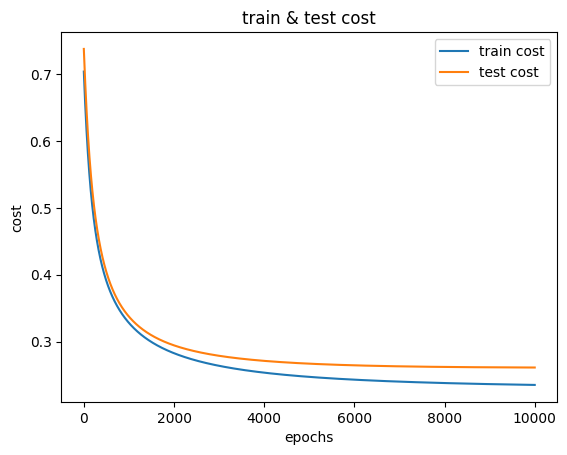

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(0, 10000), train_cost_hist, label="train cost")
plt.plot(range(0, 10000), test_cost_hist, label="test cost")
plt.title("train & test cost")
plt.xlabel("epochs")
plt.ylabel("cost")
plt.legend()
plt.show()

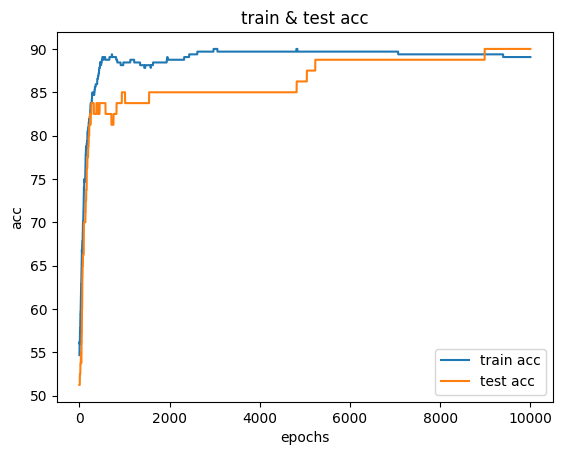

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(0, 10000), train_acc_hist, label="train acc")
plt.plot(range(0, 10000), test_acc_hist, label="test acc")
plt.title("train & test acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

In [ ]:
model.eval()
with torch.inference_mode():
  y_pred = model(x_test)
(torch.round(y_pred)==y_test).sum() / len(y_test) * 100

tensor(90., device='cuda:0')